# Importing Libraries

In [1]:
'''IMPORTING Libraries'''
import pandas as pd
import os,time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold,KFold
from sklearn.metrics import f1_score,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score,plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from category_encoders import TargetEncoder
import imblearn

In [2]:
'''Loading Data '''
test=pd.read_csv('../input/analytics-vidhya-loan-prediction/train.csv')
train=pd.read_csv('../input/analytics-vidhya-loan-prediction/train.csv')


'''Checking the data '''
print(train.head())
print(test.head())



    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

In [3]:
'''setting random seed for reproducability'''
seed=7
def set_seed(seed):
    np.random.seed(seed)
    os.PYTHONHASHSEED.set_seed(str(seed))

plt.style.use('Solarize_Light2')
plt.rcParams['font.size']=7



In [4]:
'''Checking for null values and dtypes'''
# print(train.isnull().sum())
# print(test.isnull().sum())

#info()
# print(train.info())
# print(test.info())



'Checking for null values and dtypes'

In [5]:
'''Imputing the missing values and encoding the categorical values'''
# Target variable: 'Loan_Status'
train['Loan_Status']=train['Loan_Status'].replace({'Y':1,'N':0})

# 1) missing numerical values
numerical_cols=[col for col in train.columns if train[col].dtype in ['float','int']]
numerical_cols.remove('Credit_History')
numerical_cols.remove('Loan_Status')
#imputing with the mean value.
imp_mn=SimpleImputer(strategy='mean')  #impute with mean
train[numerical_cols]=imp_mn.fit_transform(train[numerical_cols])
test[numerical_cols]=imp_mn.fit_transform(test[numerical_cols])

#imputing with most_frequent values:
imp_mf=SimpleImputer(strategy='most_frequent')  #impute with most frequent
train['Credit_History']= imp_mf.fit_transform(np.array(train['Credit_History']).reshape(-1,1))
test['Credit_History']= imp_mf.fit_transform(np.array(test['Credit_History']).reshape(-1,1))



In [6]:
# 2) missing categorical values:
# 2,1) Ordinal Variables: 'Dependents','Education','Property_Area'
ord=['Dependents','Education','Property_Area']
train[ord]=imp_mf.fit_transform(train[ord])
test[ord]=imp_mf.fit_transform(test[ord])

#encoding Education
# train['Education']=train['Education'].replace({'Graduate':1,'Not Graduate':0})
# test['Education']=test['Education'].replace({'Graduate':1,'Not Graduate':0})

#
# train['Property_Area']=train['Property_Area'].replace({'Urban':3,'Semiurban':2,'Rural':1})
# test['Property_Area']=test['Property_Area'].replace({'Urban':3,'Semiurban':2,'Rural':1})

#2,2)Nominal Variables: 'Gender' ,'Married','Self_Employed'
nom=['Gender' ,'Married','Self_Employed']
train[nom]=imp_mf.fit_transform(train[nom])
test[nom]=imp_mf.fit_transform(test[nom])

# train['Married']=train['Married'].replace({'Yes':1 ,'No':0})
# test['Married']=test['Married'].replace({'Yes':1 ,'No':0})
#
# train['Self_Employed']=train['Self_Employed'].replace({'Yes':1,'No':0})
# test['Self_Employed']=test['Self_Employed'].replace({'Yes':1,'No':0})

'''creating new features '''
train['DtIR']=((train['ApplicantIncome'] +train['CoapplicantIncome']) /(train['LoanAmount'] * 10e+3))   #debt to income ratio
test['DtIR']=((test['ApplicantIncome'] + train['CoapplicantIncome'])/(test['LoanAmount']))



In [7]:
'''dropping features and making data ready for testing'''
#setting target and X:
#reset index
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

X1=train.drop(['Loan_ID','Loan_Status','Gender'],axis=1)

y_true= test['Loan_Status']
X_test=test.drop(['Loan_ID','Gender','Loan_Status'],axis=1)

X_test_ID=test.Loan_ID
y=train['Loan_Status']



In [8]:
#target encoding
tr=TargetEncoder()
X=tr.fit_transform(X1,y)
X_test=tr.transform(X_test)

#one hot encoding
# X=pd.get_dummies(X,drop_first=True)
# X_test=pd.get_dummies(X_test,drop_first=True)


/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [9]:
assert X.shape==X_test.shape

# EDA

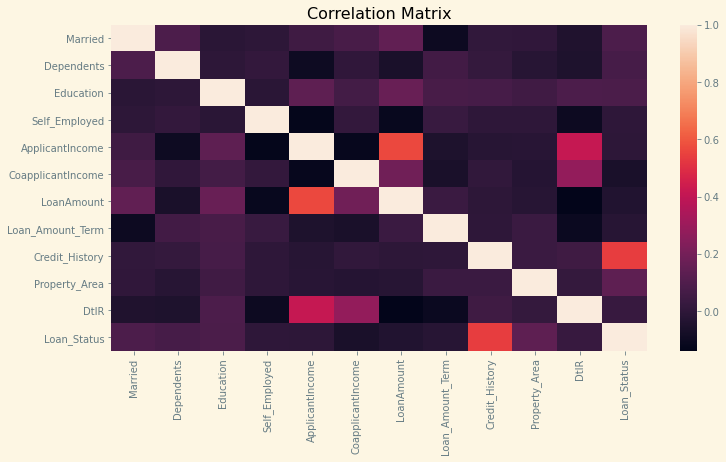

In [10]:
#correlation matrix
plt.figure(figsize=(12,6))
plt.rcParams['font.size']=10
X_c=X.copy()
X_c['Loan_Status']=y
correl=X_c.corr()
sns.heatmap(correl)
plt.title('Correlation Matrix')
plt.show()


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


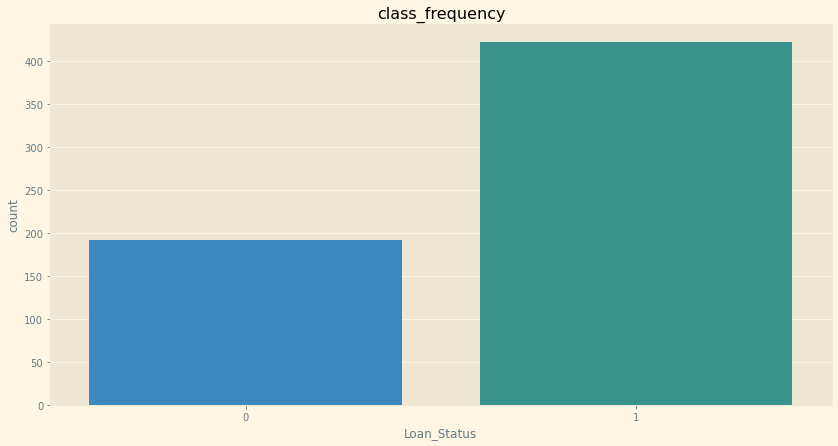

In [11]:
'''checking the class balance'''
plt.figure(figsize=(14,7))
sns.countplot(y)
plt.title('class_frequency')
plt.show()


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


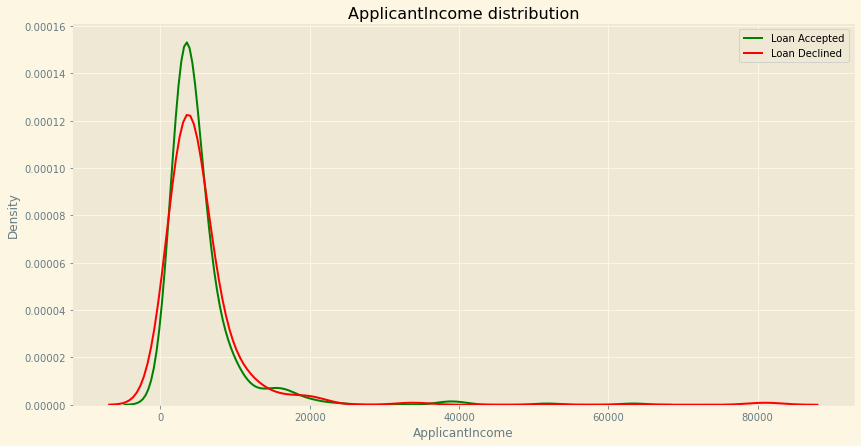

In [12]:
def plot_dist(df,col):
    df1=df[df['Loan_Status']==1]
    df0=df[df['Loan_Status']==0]
    plt.figure(figsize=(14,7))
    plt.title(f'{col} distribution')
    sns.distplot(df1[col],hist=False,color='g',label='Loan Accepted')
    sns.distplot(df0[col],hist=False,color='r',label='Loan Declined')
    plt.legend()
    plt.show()

#ApplicantIncome:
plot_dist(train,'ApplicantIncome')


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


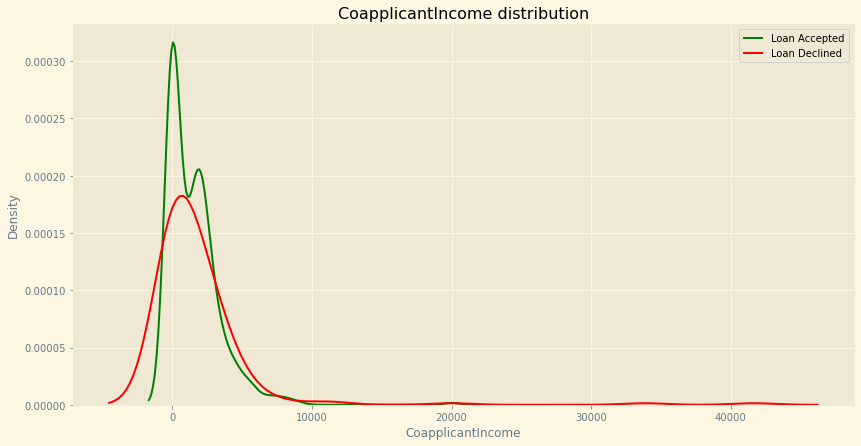

In [13]:

# #CoapplicantIncome:
plot_dist(train,'CoapplicantIncome')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


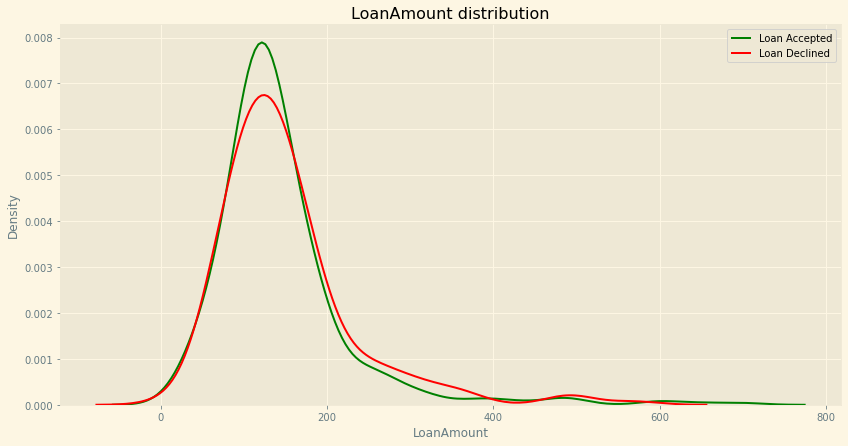

In [14]:
# #LoanAmount:
plot_dist(train,'LoanAmount')


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


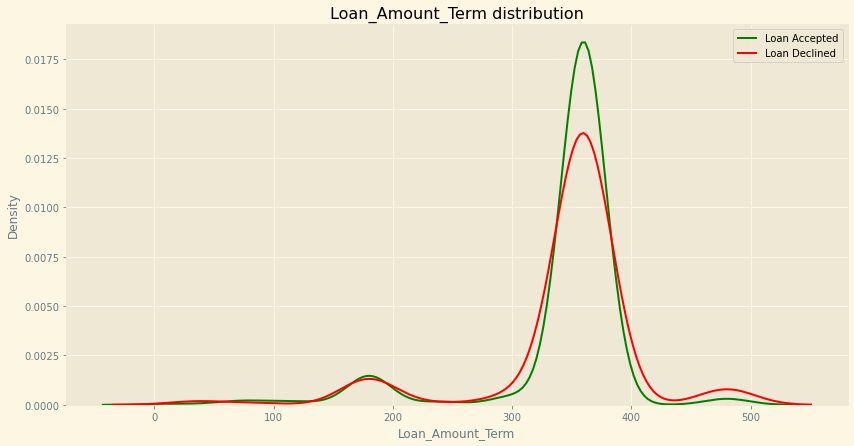

In [15]:
#Term:
plot_dist(train,'Loan_Amount_Term')


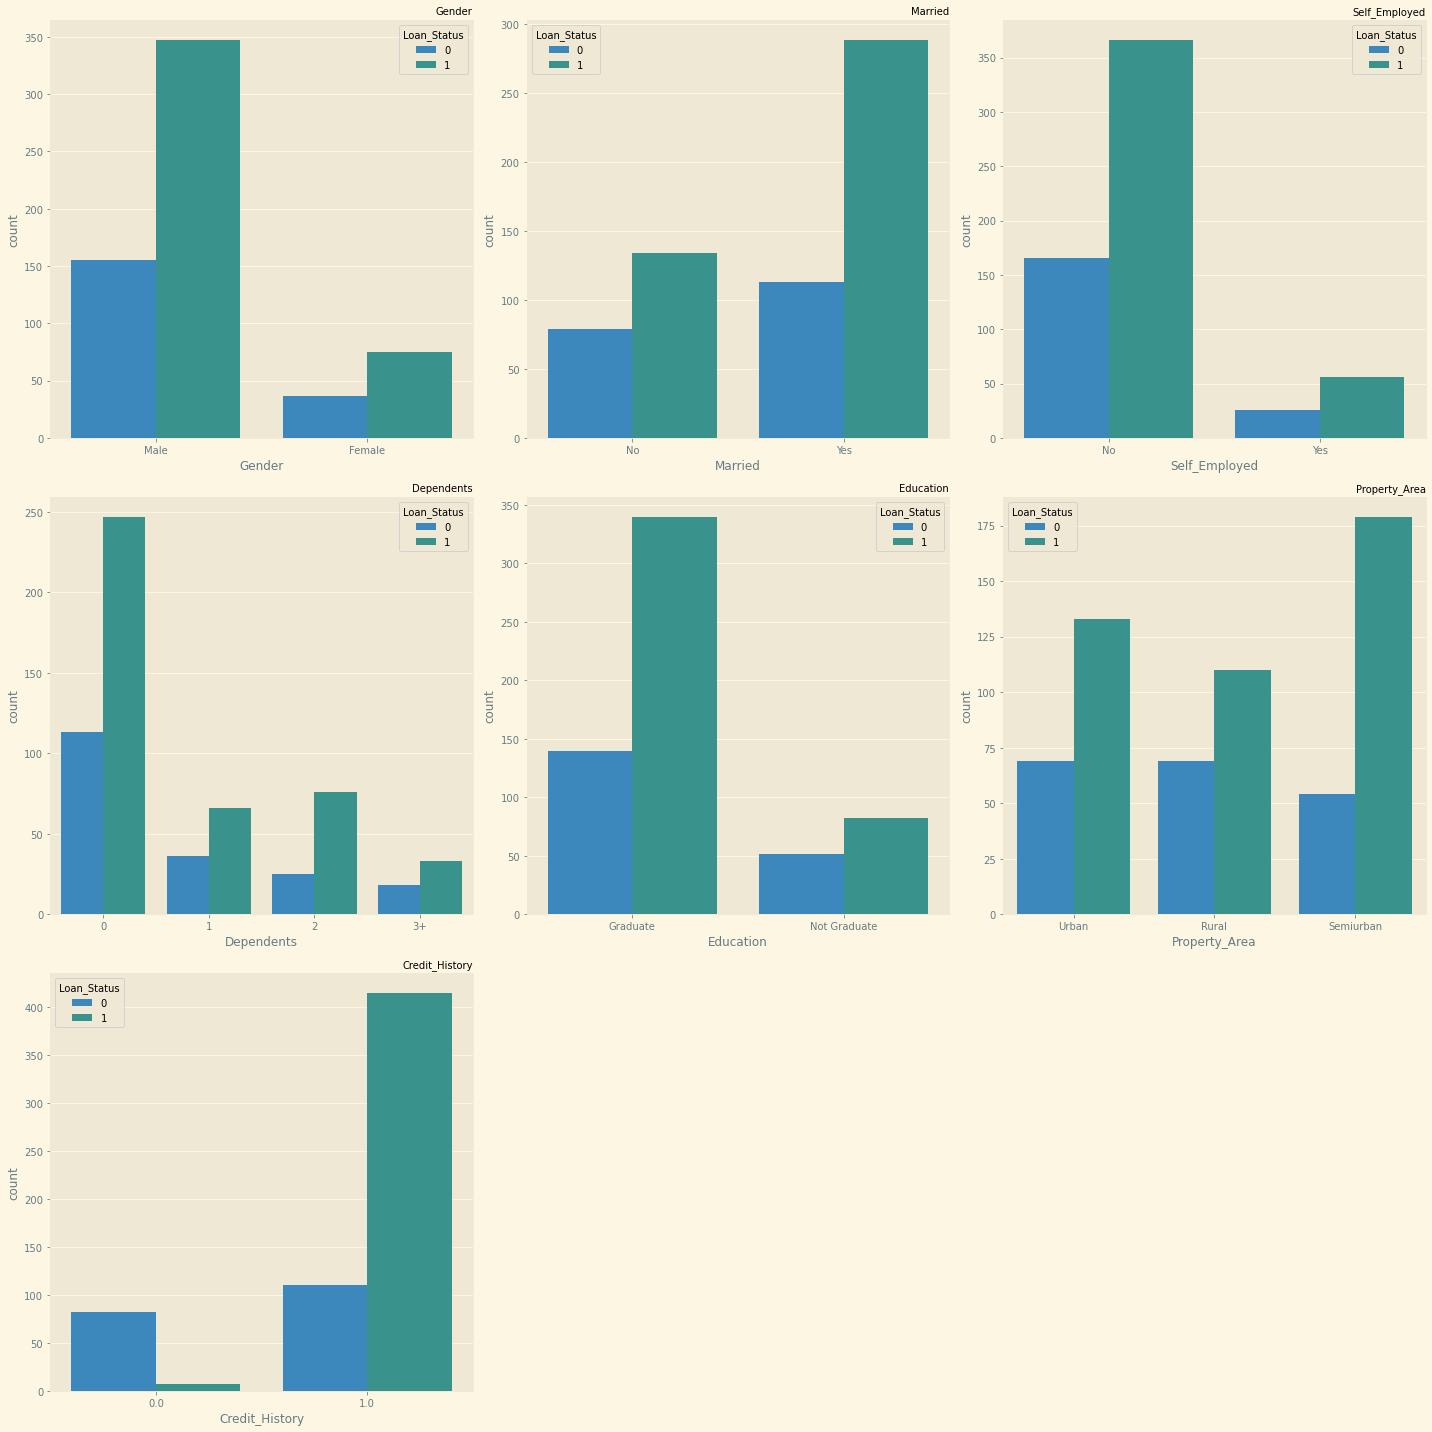

In [16]:
cat_cols=['Gender','Married','Self_Employed','Dependents','Education','Property_Area','Credit_History']

def plot_countplot(df,cols):
    plt.figure(figsize=(20,20))
    for i,col in enumerate(cols):
        plt.subplot(3,3,i+1)
        sns.countplot(x=col,data=df,hue='Loan_Status')
        plt.title(f'{col}',size=10,loc='right')
    plt.tight_layout()
    plt.show()

plot_countplot(train,cat_cols)


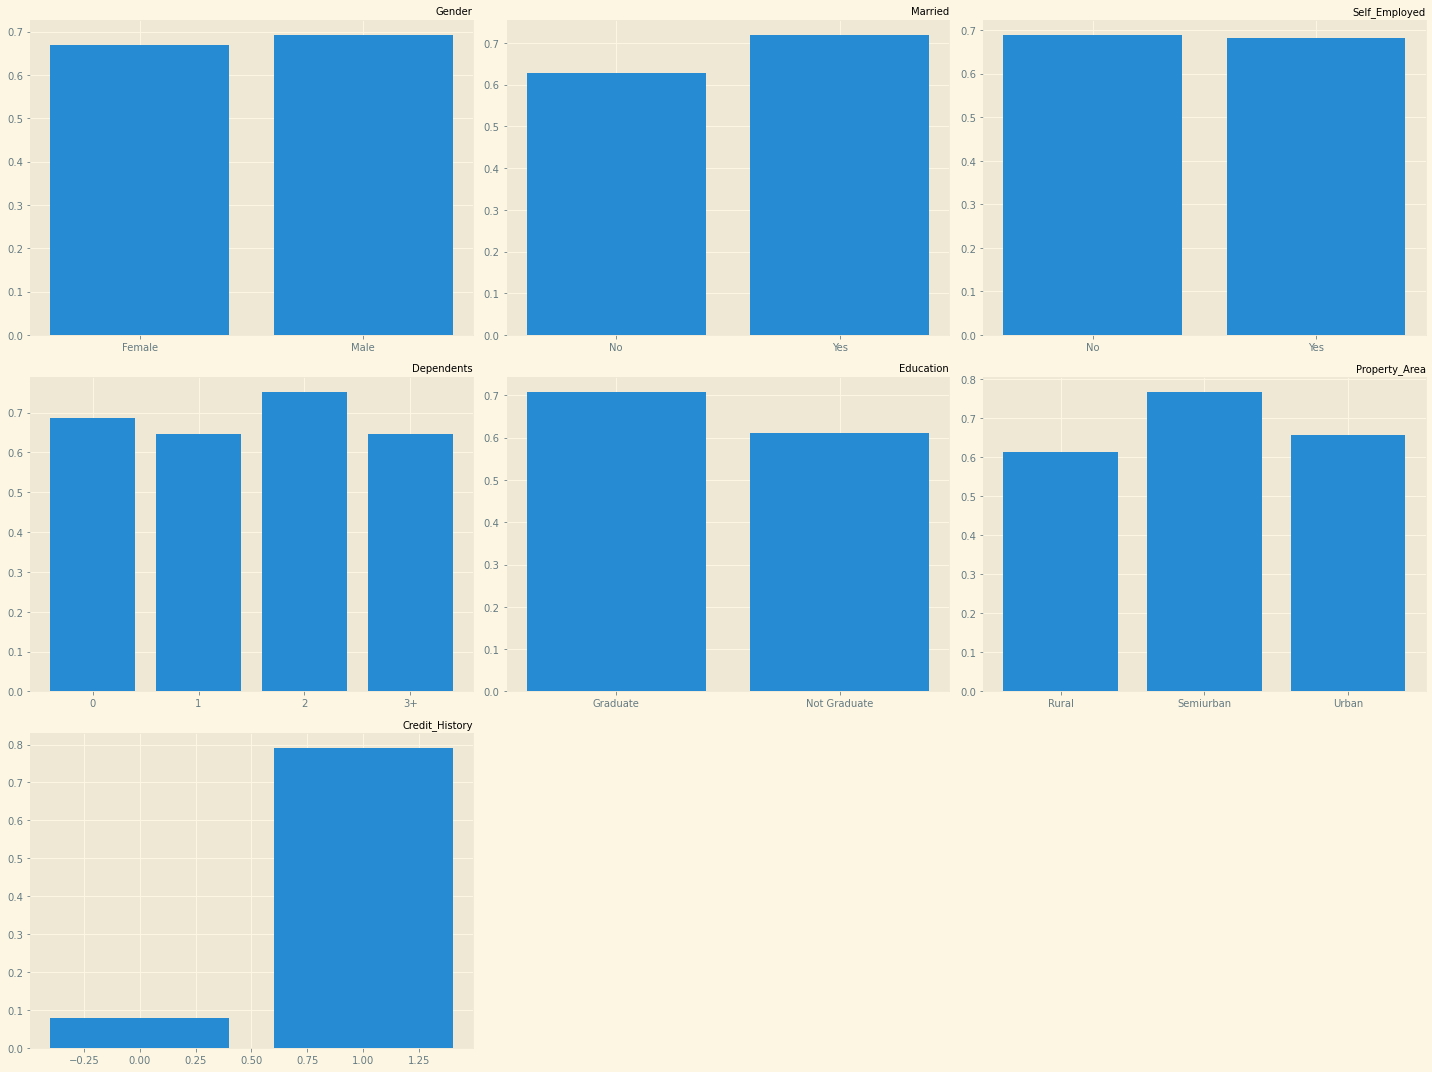

In [17]:
def plot_probs(df,cols):
    plt.figure(figsize=(20,15))
    for i,col in enumerate(cols):
        grp_mean=df.groupby(col)['Loan_Status'].mean()
        plt.subplot(3,3,i+1)
        plt.bar(grp_mean.index,grp_mean)
        plt.title(f'{col}',size=10,loc='right')
    plt.tight_layout()
    plt.show()

plot_probs(train,cat_cols)




# Training:

In [18]:
'''Scaling'''

scaler=MinMaxScaler()
scaler.fit(np.vstack((X,X_test)))
X = scaler.transform(X)
X_test=scaler.transform(X_test)
print(X.shape,X_test.shape)


(614, 11) (614, 11)


In [19]:
'''Cross Validation on diffrent models'''

skf=KFold(n_splits=7,random_state=seed,shuffle=True)

#logistic:
log_reg=LogisticRegression(random_state=seed ,C= 0.01, penalty= 'l1',solver='liblinear')

#ensembles:
Random_forest=RandomForestClassifier(n_estimators= 500,min_samples_split=8,
bootstrap= True, max_depth= 80, max_features= 3, min_samples_leaf= 5,random_state=seed)
AdaBoost=AdaBoostClassifier(n_estimators=300,random_state=seed)
GBMC=GradientBoostingClassifier(n_estimators=300,random_state=seed)

#KnearestKneighbors:
KNNC=KNeighborsClassifier()


#CROSS VAL SCORE:

models=[log_reg,KNNC,Random_forest,GBMC,AdaBoost]

for model in models:
    score=cross_val_score(model,X,y,cv=skf)
    print(f'Mean Cross val Score with {model} is {score.mean()} +/- {score.std()}')




Mean Cross val Score with LogisticRegression(C=0.01, penalty='l1', random_state=7, solver='liblinear') is 0.8095238095238094 +/- 0.02984398113502557
Mean Cross val Score with KNeighborsClassifier() is 0.7849679056575607 +/- 0.027299673212927082
Mean Cross val Score with RandomForestClassifier(max_depth=80, max_features=3, min_samples_leaf=5,
                       min_samples_split=8, n_estimators=500, random_state=7) is 0.8127892222719808 +/- 0.02655797076408289
Mean Cross val Score with GradientBoostingClassifier(n_estimators=300, random_state=7) is 0.7557284669353636 +/- 0.04228606973009524
Mean Cross val Score with AdaBoostClassifier(n_estimators=300, random_state=7) is 0.7622966114345424 +/- 0.032432854460352455


# HyperParameter Optimization 

In [20]:
'''hyper parameter tuning for random forest '''
# params= {'bootstrap': [True],
#         'max_depth': [80, 90, 100, 110],
#         'max_features': [2, 3],
#         'min_samples_leaf': [3, 4, 5],
#         'min_samples_split': [8, 10, 12],
#         'n_estimators': [300, 600, 1000]}

# grid_search = GridSearchCV(estimator = Random_forest, param_grid = params,
#                           cv = 5, n_jobs = -1, verbose = 2)
#
# grid_search.fit(X,y)
#
# best_params=grid_search.best_params_
#
# print(best_params)

#  Hyperparameter tuning for logistic regression

# params={'penalty':['l1','l2'] , 'C':[1e-3,1e-2,1e-1, 1,1e+1,1e+2,1e+3] }

# grid_search=GridSearchCV(estimator=log_reg,param_grid=params,cv=5,n_jobs=-1,verbose=2)

# grid_search.fit(X,y)

# best_params=grid_search.best_params_
# best_params



'hyper parameter tuning for random forest '

# Predictions

In [21]:
'''Predictions'''




'''training model on 5 folds and taking the mean of predictions '''
preds=[]
score=[]

for train_index, test_index in skf.split(X,y):
      X_train, x_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      Random_forest.fit(X_train,y_train)
      KNNC.fit(X_train,y_train)
      log_reg.fit(X_train,y_train)
      score.append((Random_forest.score(x_test,y_test)+log_reg.score(x_test,y_test)+KNNC.score(x_test,y_test))/3)
      

      #prediction
      rf=Random_forest.predict(X_test)
      lr=log_reg.predict(X_test)
      knn=KNNC.predict(X_test)
      
      mean_pred=[(rf[i]+lr[i] + knn[i])/3 for i in range(len(rf))]
      preds.append(mean_pred)
print(np.mean(score))
preds=np.array(preds)
mean_preds=np.mean(a=preds,axis=0)

print(mean_preds)



0.802426979151117
[1.         1.         1.         1.         1.         1.
 1.         0.         1.         0.85714286 1.         0.95238095
 1.         1.         1.         1.         0.9047619  0.
 1.         1.         0.         1.         0.         0.
 1.         1.         1.         1.         1.         1.
 1.         0.95238095 1.         1.         0.66666667 1.
 0.         1.         1.         1.         0.85714286 1.
 1.         1.         1.         0.85714286 1.         1.
 0.         1.         1.         1.         1.         0.9047619
 0.         1.         1.         1.         1.         1.
 1.         1.         0.         0.         0.         1.
 0.         1.         1.         0.         1.         1.
 1.         0.         1.         0.76190476 1.         1.
 0.         1.         1.         1.         0.9047619  1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         

In [22]:
y_preds=[]
# '''predicting Y if mean > threshold ,N other wise'''
for x in mean_preds:
    if x >.80:
        y_preds.append('Y')
    else :
        y_preds.append('N')

        
        
#SUBMISSION:

sub=pd.DataFrame({'Loan_ID':X_test_ID , 'Loan_Status':y_preds})
print(sub['Loan_Status'].value_counts())
print(sub.head(10))
sub.to_csv('loan_predictions.csv',index=False)


Y    502
N    112
Name: Loan_Status, dtype: int64
    Loan_ID Loan_Status
0  LP001002           Y
1  LP001003           Y
2  LP001005           Y
3  LP001006           Y
4  LP001008           Y
5  LP001011           Y
6  LP001013           Y
7  LP001014           N
8  LP001018           Y
9  LP001020           Y


In [23]:
y_preds=sub.Loan_Status.replace({'Y':1,'N':0})
y_true=y_true.replace({'Y':1,'N':0})

assert y_preds.shape==y_true.shape

print(f'Accuracy score on test set is {f1_score(y_preds,y_true)}')

Accuracy score on test set is 0.8874458874458876


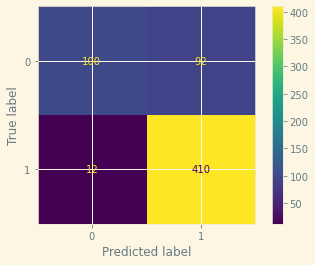

In [24]:
from sklearn.metrics import confusion_matrix


cm=confusion_matrix(y_true,y_preds)
disp=ConfusionMatrixDisplay(cm)
disp.plot()